In [7]:
#!/usr/bin/env python3

import itertools
import re
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import multitest
from SheepData import SheepData
from matplotlib import pyplot as plt


class SheepDataEvaluation():
    def __init__(self):
        self.__shd = SheepData()
        self.__sheep_folder = self.__shd.sheep_folder
        self.breeds = {1:"Charollais", 2:"Suffolk", 3:"Texel", 4:"German White-headed Mutton"}
        self.cols = {
                "Nummer":"No.", 
                "Rasse":"Breed",
                "Vater":"Sire", 
                "Mutter":"Dam", 
                "Gebmonat":"Month of birth", 
                "Gebtyp":"Type of birth", 
                "Alter_Mutter_J":"Age of dam [Years]", 
                "AblammNr":"Parturition no.",
                "Alter1_Tage":"Age 1 [d]",
                "Alter2_Tage":"Age 2 [d]",
                "Alter3_Tage":"Age 3 [d]",
                "LG1_kg":"Liveweight 1 [kg]", 
                "LG3_kg":"Liveweight 2 [kg]", 
                "TZ2_g":"Daily gain [g]", 
                "Muskeld1_mm":"Muscle tissue thickness 1 [mm]", 
                "Muskeld2_mm":"Muscle tissue thickness 2 [mm]", 
                "Fettd1_mm":"Fat tissue thickness 1 [mm]", 
                "Fett2_mm":"Fat tissue thickness 2 [mm]",
                "Fleischigk1":"Meat scoring 1", 
                "Fleischigk2":"Meat scoring 2", 
                "Bem":"Muscle scoring", 
                "Ersch":"Appearance", 
                "Zuchtwert":"Breeding value",
                "Sgwarm_kg":"Hot carcass weight [kg]", 
                "Sgkalt_kg":"Cold carcass weight [kg]",
                "Nettozun":"Net weight gain [g]",
                "Sklaenge_cm":"Carcass length [cm]",
                "Schulterb_cm":"Shoulder width [cm]", 
                "Keulenu_cm":"Shank diameter [cm]", 
                "Keulenb_cm":"Shank width [cm]",
                "Nierenf_g":"Kidney fat [g]",
                "Ofettd_cm":"Fat cover [cm]"
            }
        
    def data(self, shuffled=False):
        inferred = pd.read_csv(f"{self.__sheep_folder}/2020-07-01-Generic-Data.csv", index_col=0)
        measured = self.__shd.data_cleaning()
        if shuffled is True:
            _dset = pd.concat([inferred, measured], axis=0)
            _dset = _dset.sample(frac=1).reset_index(drop=True)
            # Solution inspire by:
            # https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows/34879805#34879805
            return _dset
        else:
            return inferred, measured
    
    def normality(self):
        inferred, measured = self.data()
        dest_vars = self.__shd.slaughter_vars + self.__shd.raising_vars
        normality_measured = pd.Series(index=dest_vars, name="Measured", dtype=np.float32)
        normality_inferred = pd.Series(index=dest_vars, name="Inferred", dtype=np.float32)
        kurtosis_measured = pd.Series(index=dest_vars, name="Measured", dtype=np.float32)
        kurtosis_inferred = pd.Series(index=dest_vars, name="Inferred", dtype=np.float32)
        q25_measured = measured.loc[:,dest_vars].quantile(0.25, axis=0).round(3)
        q25_measured.name = "Measured 0.25"
        q25_inferred = inferred.loc[:,dest_vars].quantile(0.25, axis=0).round(3)
        q25_inferred.name = "Inferred 0.25"
        q75_measured = measured.loc[:,dest_vars].quantile(0.75, axis=0).round(3)
        q75_measured.name = "Measured 0.75"
        q75_inferred = inferred.loc[:,dest_vars].quantile(0.75, axis=0).round(3)
        q75_inferred.name = "Inferred 0.75"
        m_inferred = inferred.loc[:,dest_vars].median(axis=0).round(3)
        m_inferred.name = "Median Inferred"
        m_measured = measured.loc[:,dest_vars].median(axis=0).round(3)
        m_measured.name = "Median Measured"
        var_inferred = inferred.loc[:,dest_vars].var(axis=0).round(3)
        var_inferred.name = "Variance Inferred"
        var_measured = measured.loc[:,dest_vars].var(axis=0).round(3)
        var_measured.name = "Variance Measured"
        levene_inferred = pd.Series(index=dest_vars, name="Inferred", dtype=np.float32).round(3)
        levene_measured = pd.Series(index=dest_vars, name="Measured", dtype=np.float32).round(3)
        grouped_infer = inferred.groupby("Rasse")
        grouped_meas = inferred.groupby("Rasse")
        for i in dest_vars:
            normality_inferred.loc[i] = stats.shapiro(inferred.loc[:,i].dropna().values).pvalue
            normality_measured.loc[i] = stats.shapiro(measured.loc[:,i].dropna().values).pvalue
            # The interpretation for the shapiro-wilk test is the same as in R, 
            # p < alpha = rejection of null hypothesis --> sample not drawn from normality
            kurtosis_measured.loc[i] = stats.kurtosistest(measured.loc[:,i], nan_policy="omit").pvalue
            kurtosis_inferred.loc[i] = stats.kurtosistest(inferred.loc[:,i], nan_policy="omit").pvalue
            # The interpretation is the same is in the previous normal test sample:
            # null hypothesis is the sample is drawn from normal distribution,
            # p < alpha = rejection of null hypothesis, sample does not represent normal 
            # distribution
        normality_inferred = normality_inferred.round(3)
        normality_measured = normality_measured.round(3)
        kurtosis_inferred = kurtosis_inferred.round(3)
        kurtosis_measured = kurtosis_measured.round(3)
        normality = pd.concat([normality_inferred, normality_measured], axis=1)
        normality.columns = pd.MultiIndex.from_arrays(
            [
                list(itertools.repeat("Normality", len(normality.columns))), 
                normality.columns
            ], names=["Measure", "Origin"]
        )
        kurtosis = pd.concat([kurtosis_inferred, kurtosis_measured], axis=1)
        kurtosis.columns = pd.MultiIndex.from_arrays(
            [
                list(itertools.repeat("Kurtosis", len(kurtosis.columns))), 
                kurtosis.columns
            ], names=["Measure", "Origin"]
        )
        quantile = pd.concat([q25_inferred, q25_measured, q75_inferred, q75_measured, m_measured, m_inferred], axis=1)
        quantile.columns = pd.MultiIndex.from_arrays(
            [
                list(itertools.repeat("Quantile", len(quantile.columns))), 
                quantile.columns
            ], names=["Measure", "Origin"]
        )
        variance = pd.concat([var_inferred, var_measured], axis=1)
        variance.columns = pd.MultiIndex.from_arrays(
            [
                list(itertools.repeat("Variance", len(variance.columns))),
                variance.columns
            ], names=["Measure", "Origin"]
        )
        r = pd.concat([normality, kurtosis, quantile, variance], axis=1)
        r.reset_index(inplace=True, drop=False)
        r["index"] = r["index"].apply(lambda x: self.cols[x])
        r.index = r["index"]
        r.drop("index", axis=1, inplace=True)
        return r
        
    def significancy(self, evaluated=False):
        data = self.data(shuffled=True)
        dcols = self.__shd.slaughter_vars + self.__shd.raising_vars
        pattern_weight = re.compile(r"LG[0-9]+\_kg")
        pattern_fat = re.compile(r"Fett[d0-9]+\_mm")
        pattern_muscle = re.compile(r"Muskeld[0-9]+\_mm")
        pattern_meat = re.compile(r"Fleischigk[0-9]+")
        repeated = pd.DataFrame()
        grouped = data.groupby("Rasse")
        r = pd.DataFrame()
        for rasse, _data in grouped:
            _r = pd.DataFrame(index=np.unique(data.loc[:,"Rasse"]), columns=dcols)
            _repeated = pd.DataFrame(index=np.unique(data.loc[:,"Rasse"]), columns=dcols)
            for _rasse, __data in grouped:
                if _rasse == rasse:
                    continue
                else:
                    for v in dcols:
                        _r.loc[_rasse, v] = np.around(stats.kruskal(
                            np.log10(_data.loc[:,v].dropna().values.reshape(-1,1)), 
                            np.log10(__data.loc[:,v].dropna().values.reshape(-1,1)),
                            nan_policy="omit"
                        ).pvalue, 3)
                        if pattern_weight.match(v) or pattern_fat.match(v) or pattern_muscle.match(v) or pattern_meat.match(v):
                            _repeated.loc[_rasse, v] = np.around(stats.kruskal(
                                np.log10(_data.loc[:,v].dropna().values.reshape(-1,1)), 
                                np.log10(__data.loc[:,v].dropna().values.reshape(-1,1)),
                                nan_policy="omit"
                            ).pvalue, 3)
                            # The null hypothesis for scipy.stats.kruskal is that all values are 
                            # drawn from a distribution with the same median. Thus, a p-value higher
                            # than alpha proves the null hypothesis, while a p-value smaller than 
                            # alpha is bound to reject it
            _repeated.dropna(how="all", axis=0, inplace=True)
            _r.reset_index(inplace=True, drop=False)
            _r["index"] = _r["index"].apply(lambda x: self.breeds[x])
            _r.index = _r["index"]
            _r.drop("index", axis=1, inplace=True)
            _r.dropna(how="all", axis=0, inplace=True)
            _r.index = pd.MultiIndex.from_arrays(
                [list(itertools.repeat(self.breeds[rasse], len(_r.index))), _r.index], 
                names=["Breed", "Comparisons"]
            )
            _repeated.reset_index(inplace=True, drop=False)
            _repeated["index"] = _repeated["index"].apply(lambda x: self.breeds[x])
            _repeated.index = _repeated["index"]
            _repeated.drop("index", axis=1, inplace=True)
            _repeated.index = pd.MultiIndex.from_arrays(
                [list(itertools.repeat(self.breeds[rasse], len(_repeated.index))), _repeated.index], 
                names=["Breed", "Comparisons"]
            )
            r = pd.concat([r, _r], axis=0)
            repeated = pd.concat([repeated, _repeated], axis=0)
            repeated.dropna(how="all", axis=1, inplace=True)
        repeated_eval = pd.DataFrame(
            index=repeated.index, columns=repeated.columns
        )
        for c in repeated.columns:
            corrections = multitest.multipletests(
                repeated.loc[:,c], method="holm", alpha=0.05, is_sorted=False
            )
            if evaluated is True:
                repeated_eval.loc[:,c] = corrections[0]
            else:
                corrections[1][corrections[1] == 1] = 0
                repeated_eval.loc[:,c] = corrections[1]
        if evaluated is True:
            r = r > 0.05
        repeated_eval.rename(self.cols, axis=1, inplace=True)
        r.rename(self.cols, axis=1, inplace=True)
        return pd.concat([r, repeated_eval], axis=1)
    
    def medians(self, plotting=False, save=False):
        data = self.data(shuffled=True)
        dcols = self.__shd.slaughter_vars + self.__shd.raising_vars + ["Rasse"]
        data = data.loc[:,dcols]
        grouped = data.groupby("Rasse")
        res = pd.DataFrame(index=np.unique(data.loc[:,"Rasse"]), columns=dcols)
        for breed, _data in grouped:
            res.loc[breed, :] = _data.median(axis=0).round(2)
        res.drop("Rasse", axis=1, inplace=True)
        res.rename(self.cols, axis=1, inplace=True)
        res.reset_index(inplace=True, drop=False)
        res["index"] = res["index"].apply(lambda x: self.breeds[x])
        res.index = res["index"]
        res.drop("index", axis=1, inplace=True)
        if plotting is True:
            breed_colors = {
                "Charollais":"xkcd:light blue", 
                "Suffolk":"xkcd:light green", 
                "Texel":"xkcd:navy blue", 
                "German Whiteheaded Mutton":"xkcd:orange"
            }
            fig, ax = plt.subplots(figsize=(15,10))
            ax.bar(
                np.arange(len(res.columns)) - 0.4, 
                res.iloc[0,:], label=res.index[0], 
                color=breed_colors[res.index[0]], 
                width=0.2
            )
            ax.bar(
                np.arange(len(res.columns)) - 0.2, 
                res.iloc[1,:], label=res.index[1], 
                color=breed_colors[res.index[1]], 
                width=0.2
            )
            ax.bar(
                np.arange(len(res.columns)), 
                res.iloc[2,:], 
                label=res.index[2], 
                color=breed_colors[res.index[2]], 
                width=0.2
            )
            ax.bar(
                np.arange(len(res.columns)) + 0.2, 
                res.iloc[3,:], 
                label=res.index[3], 
                color=breed_colors[res.index[3]], 
                width=0.2
            )
            ax.set_yscale("log")
            ax.set_xticks(np.arange(len(res.columns)))
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fontsize=14)
            ax.set_xticklabels(res.columns, rotation=45, ha="right")
            ax.set_title("Medians for all breeds included in the analysis", fontweight="bold", fontsize=16)
            if save is True:
                plt.savefig("../Paper/Inferring of data sets for phenotypic data/Medians.png", bbox_inches='tight')
        return res.T

#SheepDataEvaluation().normality()#.to_excel("../Daten/Schafe/Normality-Test.xlsx", float_format="%.3f")
SheepDataEvaluation().significancy()#.to_csv("../Daten/Schafe/2020-07-16 Results-Kruskal-Wallis.csv")

/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10


Hot carcass weight [kg]  \
Breed                      Comparisons                                          
Charollais                 Suffolk                                      0.038   
                           Texel                                        0.114   
                           German White-headed Mutton                   0.115   
Suffolk                    Charollais                                   0.038   
                           Texel                                        0.501   
                           German White-headed Mutton                   0.344   
Texel                      Charollais                                   0.114   
                           Suffolk                                      0.501   
                           German White-headed Mutton                   0.681   
German White-headed Mutton Charollais                                   0.115   
                           Suffolk                                      0.344   
                           Texel                                        0.681   

                                                      Cold carcass weight [kg]  \
Breed                      Comparisons                                           
Charollais                 Suffolk                                       0.042   
                           Texel                                         0.124   
                           German White-headed Mutton                    0.117   
Suffolk                    Charollais                                    0.042   
                           Texel                                          0.56   
                           German White-headed Mutton                    0.344   
Texel                      Charollais                                    0.124   
                           Suffolk                                        0.56   
                           German White-headed Mutton                    0.678   
German White-headed Mutton Charollais                                    0.117   
                           Suffolk                                       0.344   
                           Texel                                         0.678   

                                                      Net weight gain [g]  \
Breed                      Comparisons                                      
Charollais                 Suffolk                                  0.132   
                           Texel                                     0.58   
                           German White-headed Mutton               0.186   
Suffolk                    Charollais                               0.132   
                           Texel                                    0.291   
                           German White-headed Mutton               0.477   
Texel                      Charollais                                0.58   
                           Suffolk                                  0.291   
                           German White-headed Mutton               0.614   
German White-headed Mutton Charollais                               0.186   
                           Suffolk                                  0.477   
                           Texel                                    0.614   

                                                      Carcass length [cm]  \
Breed                      Comparisons                                      
Charollais                 Suffolk                                  0.593   
                           Texel                                    0.262   
                           German White-headed Mutton                0.35   
Suffolk                    Charollais                               0.593   
                           Texel                                     0.58   
                           German White-headed Mutton               0.703   
Texel                      Charollais                               0.262  

In [4]:
SheepDataEvaluation().significancy(evaluated=True)#.columns

/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10


Index(['Hot carcass weight [kg]', 'Cold carcass weight [kg]',
       'Net weight gain [g]', 'Carcass length [cm]', 'Shoulder width [cm]',
       'Shank diameter [cm]', 'Shank width [cm]', 'Kidney fat [g]',
       'Fat cover [cm]', 'Muscle Tissue Thickness 1 [mm]',
       'Muscle Tissue Thickness 2 [mm]', 'Fat Tissue Thickness 1 [mm]',
       'Fat Tissue Thickness 2 [mm]', 'Meat Scoring 1', 'Meat Scoring 2',
       'Muscle Scoring', 'Liveweight 1 [kg]', 'Liveweight 2 [kg]',
       'Daily Gain [g]', 'Muskeld1_mm', 'Muskeld2_mm', 'Fettd1_mm', 'Fett2_mm',
       'Fleischigk1', 'Fleischigk2', 'LG1_kg', 'LG3_kg'],
      dtype='object')

In [32]:
d = SheepDataEvaluation().normality()
kurtosis = d.loc[:,pd.IndexSlice["Kurtosis",:]]
kurtosis.columns = kurtosis.columns.droplevel(0)
normal_inf = kurtosis["Inferred"].loc[kurtosis["Inferred"] < 0.05]
normal_me = kurtosis["Measured"].loc[kurtosis["Measured"] < 0.05]
pd.concat([normal_inf, normal_me], axis=1)

Inferred  Measured
Sgwarm_kg     0.000292  0.041961
Sgkalt_kg     0.000283  0.049965
Nettozun      0.000205       NaN
Sklaenge_cm   0.000235       NaN
Schulterb_cm  0.000212       NaN
Keulenu_cm    0.000219       NaN
Keulenb_cm    0.000202       NaN
Ofettd_cm     0.002003  0.030800
Muskeld1_mm   0.003455       NaN
Muskeld2_mm   0.003455       NaN
Fettd1_mm     0.003455       NaN
Fett2_mm      0.003455  0.006995
Fleischigk1   0.003455       NaN
Fleischigk2   0.003455       NaN
Bem           0.003455       NaN
LG1_kg        0.003455       NaN
LG3_kg        0.003455       NaN
TZ2_g         0.003455       NaN

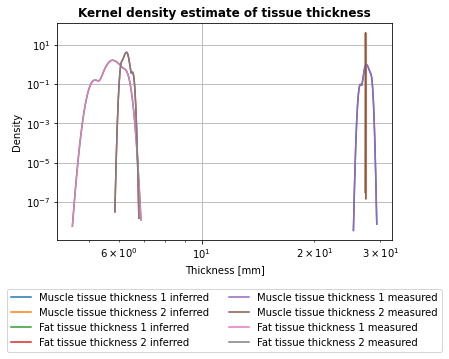

In [10]:
def kde_mm():
    pattern_mm = re.compile(r"[A-Za-z0-9]+\_mm")
    inferred, measured = SheepDataEvaluation().data()
    inferred_mm = inferred.loc[:,list(filter(pattern_mm.match, inferred.columns))].dropna()
    inferred_mm.columns = ["Muscle tissue thickness 1", "Muscle tissue thickness 2", "Fat tissue thickness 1", "Fat tissue thickness 2"]
    measured_mm = inferred.loc[:,list(filter(pattern_mm.match, measured.columns))].dropna()
    measured_mm.columns = inferred_mm.columns
    inferred_mm.columns = [f"{x} inferred" for x in inferred_mm.columns]
    measured_mm.columns = [f"{_x} measured" for _x in measured_mm.columns]
    mm = pd.concat([inferred_mm, measured_mm], axis=1)
    fig_mm = mm.plot.density()
    fig_mm.set_xscale('log')
    fig_mm.set_yscale('log')
    fig_mm.set_title("Kernel density estimate of tissue thickness", weight="bold")
    fig_mm.set_xlabel("Thickness [mm]")
    fig_mm.grid()
    lgd = fig_mm.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    #plt.savefig("../Paper/Inferring of data sets for phenotypic data/KDE-mm.pgf", bbox_inches="tight")
    
kde_mm()

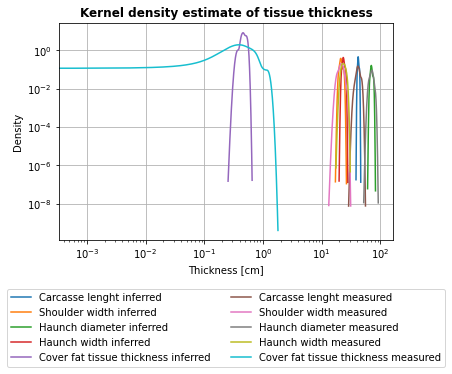

In [7]:
def kde_cm():
    inferred, measured = SheepDataEvaluation().data()
    pattern_cm = re.compile(r"[A-Za-z0-9]+\_cm")
    inferred_cm = inferred.loc[:,list(filter(pattern_cm.match, inferred.columns))].dropna()
    inferred_cm.columns = ["Carcasse lenght", "Shoulder width", "Haunch diameter", "Haunch width", "Cover fat tissue thickness"]
    measured_cm = measured.loc[:,list(filter(pattern_cm.match, measured.columns))].dropna()
    measured_cm.columns = inferred_cm.columns
    inferred_cm.columns = [f"{_x} inferred" for _x in inferred_cm.columns]
    measured_cm.columns = [f"{_x_} measured" for _x_ in measured_cm.columns]
    cm = pd.concat([inferred_cm, measured_cm], axis=1)
    fig_cm = cm.plot.density()
    fig_cm.set_xscale('log')
    fig_cm.set_yscale('log')
    fig_cm.set_title("Kernel density estimate of tissue thickness", weight="bold")
    fig_cm.set_xlabel("Thickness [cm]")
    fig_cm.grid()
    lgd = fig_cm.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    #plt.savefig("../Paper/Inferring of data sets for phenotypic data/KDE-cm.pgf", bbox_inches="tight")
    
kde_cm()

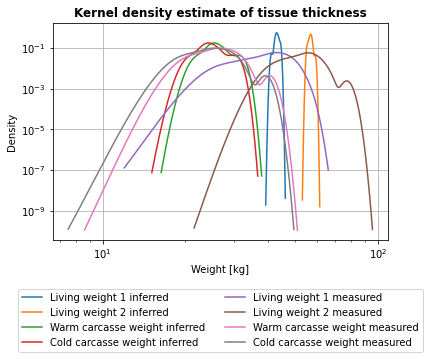

In [4]:
def kde_kg():
    inferred, measured = SheepDataEvaluation().data()
    pattern_kg = re.compile(r"[A-Za-z0-9]+\_kg")
    inferred_kg = inferred.loc[:,list(filter(pattern_kg.match, inferred.columns))].dropna()
    inferred_kg.columns = ["Living weight 1", "Living weight 2", "Warm carcasse weight", "Cold carcasse weight"]
    measured_kg = measured.loc[:,list(filter(pattern_kg.match, measured.columns))].dropna()
    measured_kg.columns = inferred_kg.columns
    inferred_kg.columns = [f"{_x} inferred" for _x in inferred_kg.columns]
    measured_kg.columns = [f"{_x_} measured" for _x_ in measured_kg.columns]
    kg = pd.concat([inferred_kg, measured_kg], axis=1)
    fig_kg = kg.plot.density()
    fig_kg.set_xscale('log')
    fig_kg.set_yscale('log')
    fig_kg.set_title("Kernel density estimate of tissue thickness", weight="bold")
    fig_kg.set_xlabel("Weight [kg]")
    fig_kg.grid()
    lgd = fig_kg.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    #plt.savefig("../Paper/Inferring of data sets for phenotypic data/KDE-kg.pgf", bbox_inches="tight")

kde_kg()

In [127]:
from statsmodels import api as sm
from statsmodels.formula.api import ols

_inferred, _ = SheepDataEvaluation().data()
_model = ols('Sgwarm_kg~Rasse*TZ2_g', data=_inferred).fit()
sm.stats.anova_lm(_model, typ=2)

sum_sq    df         F    PR(>F)
Rasse          0.001179   1.0  0.000172  0.989555
TZ2_g         59.276258   1.0  8.659924  0.004107
Rasse:TZ2_g    0.717016   1.0  0.104752  0.746927
Residual     636.575075  93.0       NaN       NaN

/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib64/python3.6/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Origin                          Variance Inferred  Variance Measured
index                                                               
Hot carcass weight [kg]                     16.73              15.41
Cold carcass weight [kg]                    16.91              15.20
Net weight gain [g]                        982.96             557.68
Carcass length [cm]                          2.44               7.78
Shoulder width [cm]                          3.65               3.42
Shank diameter [cm]                         19.81              18.53
Shank width [cm]                             2.96               2.55
Kidney fat [g]                             212.32            8082.23
Fat cover [cm]                               0.00               0.04
Muscle Tissue Thickness 1 [mm]               0.07              15.76
Muscle Tissue Thickness 2 [mm]               0.00               8.49
Fat Tissue Thickness 1 [mm]                  0.03               1.49
Fat Tissue Thickness 2 [mm]                  0.00               1.13
Meat Scoring 1                               0.00               0.98
Meat Scoring 2                               0.01               0.65
Muscle Scoring                               0.01               0.62
Liveweight 1 [kg]                            0.23              63.84
Liveweight 2 [kg]                            0.33              67.08
Daily Gain [g]                             383.75            5364.74

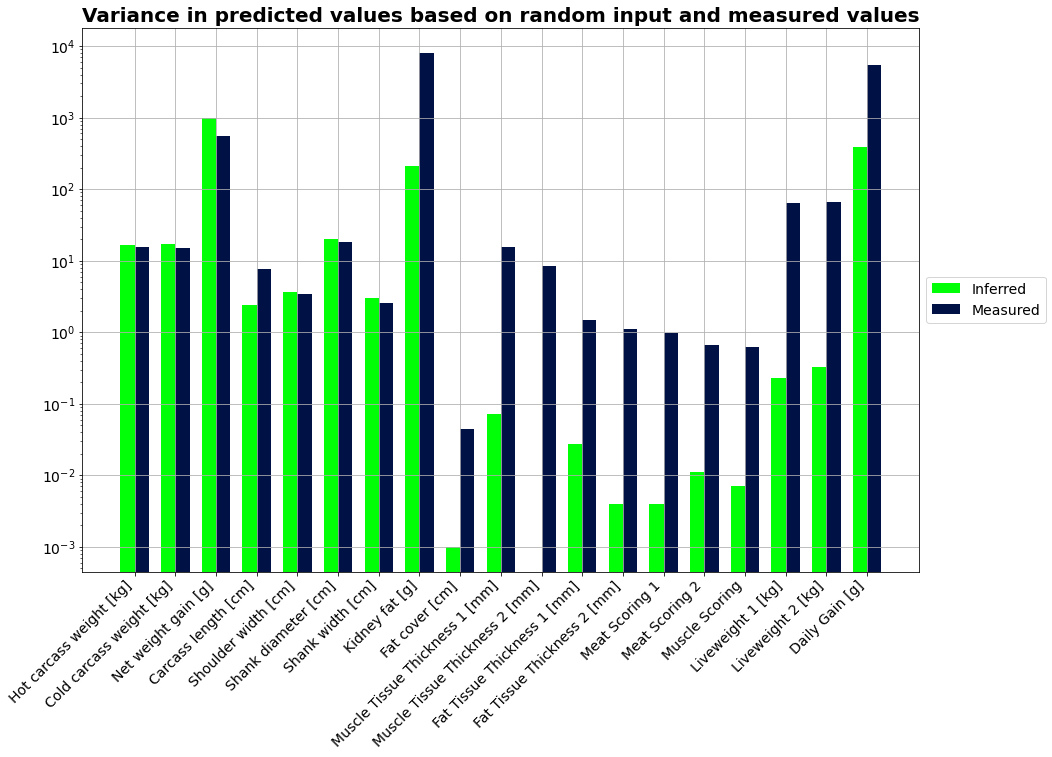

In [2]:
def plot_var():
    table = SheepDataEvaluation().normality().loc[:,pd.IndexSlice["Variance",:]].T
    cols = {
        "Nummer":"No.", 
        "Rasse":"Breed",
        "Vater":"Sire", 
        "Mutter":"Dam", 
        "Gebmonat":"Month of Birth", 
        "Gebtyp":"Type of Birth", 
        "Alter_Mutter_J":"Age of Dam [Years]", 
        "AblammNr":"Parturition No.",
        "Alter1_Tage":"Age 1 [d]",
        "Alter2_Tage":"Age 2 [d]",
        "Alter3_Tage":"Age 3 [d]",
        "LG1_kg":"Liveweight 1 [kg]", 
        "LG3_kg":"Liveweight 2 [kg]", 
        "TZ2_g":"Daily Gain [g]", 
        "Muskeld1_mm":"Muscle Tissue Thickness 1 [mm]", 
        "Muskeld2_mm":"Muscle Tissue Thickness 2 [mm]", 
        "Fettd1_mm":"Fat Tissue Thickness 1 [mm]", 
        "Fett2_mm":"Fat Tissue Thickness 2 [mm]",
        "Fleischigk1":"Meat Scoring 1", 
        "Fleischigk2":"Meat Scoring 2", 
        "Bem":"Muscle Scoring", 
        "Ersch":"Appearance", 
        "Zuchtwert":"Breeding value",
        "Sgwarm_kg":"Hot carcass weight [kg]", 
        "Sgkalt_kg":"Cold carcass weight [kg]",
        "Nettozun":"Net weight gain [g]",
        "Sklaenge_cm":"Carcass length [cm]",
        "Schulterb_cm":"Shoulder width [cm]", 
        "Keulenu_cm":"Shank diameter [cm]", 
        "Keulenb_cm":"Shank width [cm]",
        "Nierenf_g":"Kidney fat [g]",
        "Ofettd_cm":"Fat cover [cm]"
    }
    table.rename(cols, axis=1, inplace=True)
    table.index = table.index.droplevel()
    fig, ax = plt.subplots(figsize=(15,10))
    ax.bar(
        np.arange(len(table.columns)) - 0.35/2, 
        table.loc["Variance Inferred",:].values, 
        width=0.35, label="Inferred", 
        color="xkcd:bright green"
    )
    ax.bar(
        np.arange(len(table.columns)) + 0.35/2, 
        table.loc["Variance Measured",:].values, 
        width=0.35, 
        label="Measured", 
        color="xkcd:navy blue"
    )
    ax.set_yscale("log")
    ax.set_xticks(np.arange(len(table.columns)))
    ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=14)
    ax.set_xticklabels(table.columns, rotation=45, ha="right")
    ax.tick_params(axis="both", labelsize=14)
    ax.grid()
    ax.set_title(
        "Variance in predicted values based on random input and measured values", 
        fontsize=20, fontweight="bold"
    )
    plt.savefig(
        "../Paper/Inferring of data sets for phenotypic data/Variance-Comparison.png",bbox_inches='tight')
    return table.T.round(2)

plot_var()
#with open("../Paper/Inferring of data sets for phenotypic data/Variance-Table.tex", "w+") as texfile:
#    r = plot_var().to_latex(column_format="|p{0.2\linewidth}|p{0.2\linewidth}|p{0.2\linewidth}|")
#    texfile.write(r)

In [35]:
d = SheepDataEvaluation().normality()
_index = {
        "Nummer":"No.", 
        "Rasse":"Breed",
        "Vater":"Sire", 
        "Mutter":"Dam", 
        "Gebmonat":"Month of Birth", 
        "Gebtyp":"Type of Birth", 
        "Alter_Mutter_J":"Age of Dam [Years]", 
        "AblammNr":"Parturition No.",
        "Alter1_Tage":"Age 1 [d]",
        "Alter2_Tage":"Age 2 [d]",
        "Alter3_Tage":"Age 3 [d]",
        "LG1_kg":"Liveweight 1 [kg]", 
        "LG3_kg":"Liveweight 2 [kg]", 
        "TZ2_g":"Daily Gain [g]", 
        "Muskeld1_mm":"Muscle Tissue Thickness 1 [mm]", 
        "Muskeld2_mm":"Muscle Tissue Thickness 2 [mm]", 
        "Fettd1_mm":"Fat Tissue Thickness 1 [mm]", 
        "Fett2_mm":"Fat Tissue Thickness 2 [mm]",
        "Fleischigk1":"Meat Scoring 1", 
        "Fleischigk2":"Meat Scoring 2", 
        "Bem":"Muscle Scoring", 
        "Ersch":"Appearance", 
        "Zuchtwert":"Breeding value",
        "Sgwarm_kg":"Hot carcass weight [kg]", 
        "Sgkalt_kg":"Cold carcass weight [kg]",
        "Nettozun":"Net weight gain [g]",
        "Sklaenge_cm":"Carcass length [cm]",
        "Schulterb_cm":"Shoulder width [cm]", 
        "Keulenu_cm":"Shank diameter [cm]", 
        "Keulenb_cm":"Shank width [cm]",
        "Nierenf_g":"Kidney fat [g]",
        "Ofettd_cm":"Fat cover [cm]"
    }
d.rename(_index, axis=0, inplace=True)
quantiles = d.loc[:,pd.IndexSlice["Quantile",:]]
variances = d.loc[:,pd.IndexSlice["Variance",:]]
quantiles.columns = quantiles.columns.droplevel(0)
kurtosis = d.loc[:,pd.IndexSlice["Kurtosis",:]]
kurtosis.columns = kurtosis.columns.droplevel(0)
'''
with open("../Paper/Inferring of data sets for phenotypic data/Quantile25.tex", "w+") as quantile25:
    q25 = quantiles.loc[:,["Inferred 0.25", "Measured 0.25"]].round(3).to_latex(
        column_format="|p{0.5\linewidth}|p{0.15\linewidth}|p{0.15\linewidth}|")
    quantile25.write(q25)
with open("../Paper/Inferring of data sets for phenotypic data/Quantile75.tex", "w+") as quantile75:
    q75 = quantiles.loc[:,["Inferred 0.75", "Measured 0.75"]].round(3).to_latex(
        column_format="|p{0.5\linewidth}|p{0.15\linewidth}|p{0.15\linewidth}|")
    quantile75.write(q75)
with open("../Paper/Inferring of data sets for phenotypic data/Median.tex", "w+") as median:
    med = quantiles.loc[:,["Median Inferred", "Median Measured"]].round(3).to_latex(
        column_format="|p{0.5\linewidth}|p{0.15\linewidth}|p{0.15\linewidth}|")
    median.write(med)
with open("../Paper/Inferring of data sets for phenotypic data/NormalityKurtosis.tex", "w+") as nk:
    k = kurtosis.round(3).to_latex(
        column_format="|p{0.5\linewidth}|p{0.15\linewidth}|p{0.15\linewidth}|"
    )
    nk.write(k)
'''

In [4]:
d = SheepDataEvaluation().significancy()
d_ = d.loc[:,
      [
          "Nettozun", 
          "Sklaenge_cm", 
          "Schulterb_cm", 
          "TZ2_g", 
          "Muskeld1_mm", 
          "Muskeld2_mm", 
          "Fettd1_mm", 
          "Fett2_mm", 
          "Fleischigk1", 
          "Fleischigk2", 
          "LG1_kg", 
          "LG3_kg"]
     ].T
d_.rename(_index, axis=0, inplace=True)
#with open("../Paper/Inferring of data sets for phenotypic data/KruskalResults1-2.tex", "w+") as kr12:
#    kr12.write(d_.loc[:,pd.IndexSlice[[1, 2], :]].to_latex(
#        column_format="|p{0.2\linewidth}|p{0.1\linewidth}|p{0.1\linewidth}|p{0.1\linewidth}|"
#    ))
#with open("../Paper/Inferring of data sets for phenotypic data/KruskalResults3-4.tex", "w+") as kr34:
#    kr34.write(d_.loc[:,pd.IndexSlice[[3, 4], :]].to_latex(
#        column_format="|p{0.2\linewidth}|p{0.1\linewidth}|p{0.1\linewidth}|p{0.1\linewidth}|"
#    ))
d_.loc[:,pd.IndexSlice[[3, 4], :]]

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log10
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in log10


Breed                                  3                                4  \
Comparisons                            1          2         4           1   
Net weight gain [g]             0.580313   0.291219   0.61384    0.185802   
Carcasse length [cm]            0.261847   0.580256  0.655095    0.349559   
Shoulder width [cm]             0.312635   0.381837  0.664897   0.0883023   
Daily Gain [g]                  0.856862  0.0394116  0.219779    0.235533   
Muscle Tissue Thickness 1 [mm]  0.151877   0.336059         0  0.00437048   
Muscle Tissue Thickness 2 [mm]         0          0  0.244683     0.67114   
Fat Tissue Thickness 1 [mm]            0          0         0           0   
Fat Tissue Thickness 2 [mm]      0.37722   0.622447         0    0.374456   
Meat Scoring 1                         0          0  0.854687   0.0147518   
Meat Scoring 2                         0          0         0           0   
Liveweight 1 [kg]               0.152877          0         0   0.0282093   
Liveweight 3 [kg]                      0          0         0   0.0301186   

Breed                                                
Comparisons                             2         3  
Net weight gain [g]              0.477032   0.61384  
Carcasse length [cm]             0.703098  0.655095  
Shoulder width [cm]              0.679956  0.664897  
Daily Gain [g]                   0.151348  0.219779  
Muscle Tissue Thickness 1 [mm]  0.0395447         0  
Muscle Tissue Thickness 2 [mm]   0.012609  0.244683  
Fat Tissue Thickness 1 [mm]             0         0  
Fat Tissue Thickness 2 [mm]      0.655944         0  
Meat Scoring 1                          0  0.854687  
Meat Scoring 2                          0         0  
Liveweight 1 [kg]                0.762138         0  
Liveweight 3 [kg]                0.320653         0

/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in log10
/home/thomas/.local/share/virtualenvs/Analyses-Pipenv-VxV8rABJ/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10


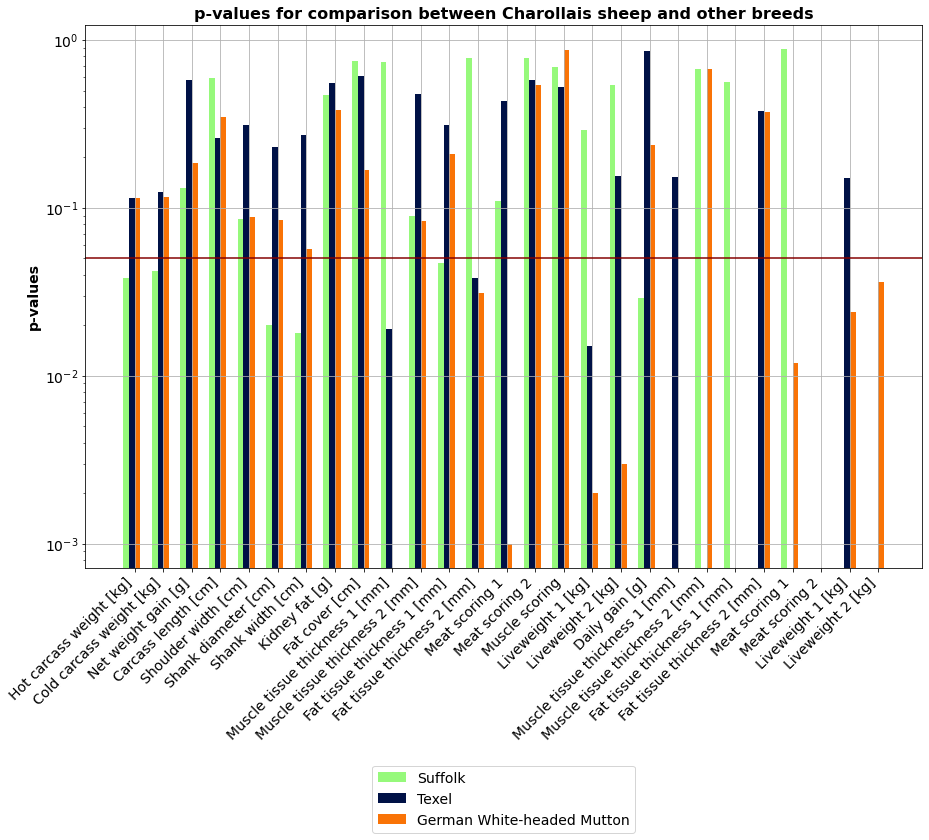

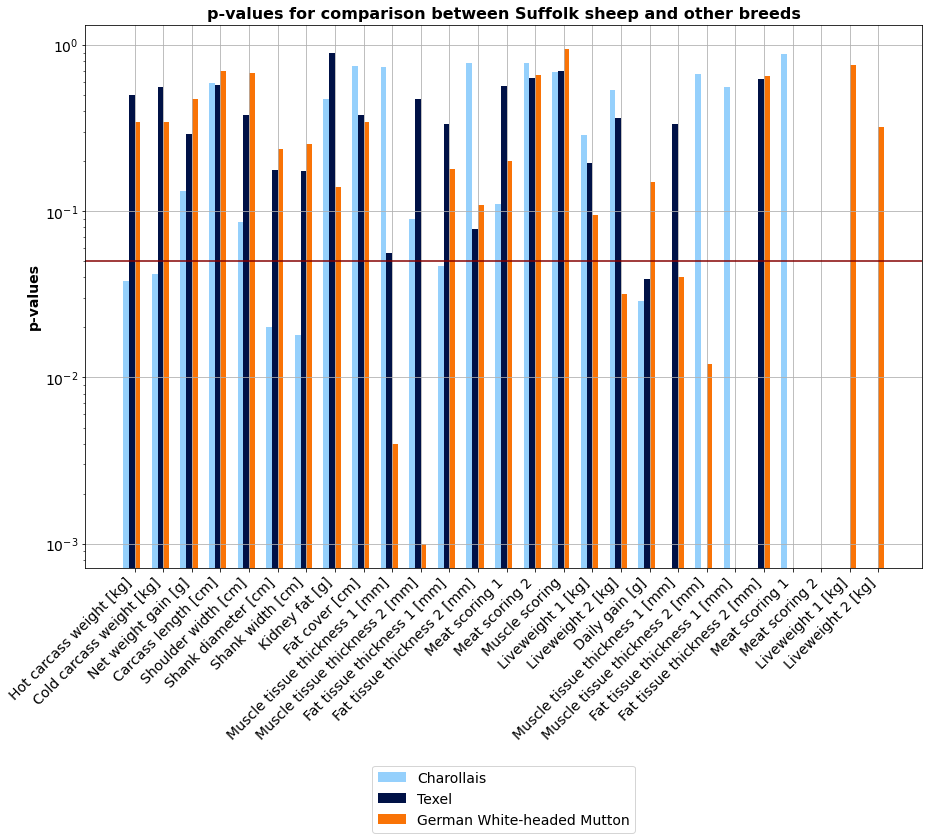

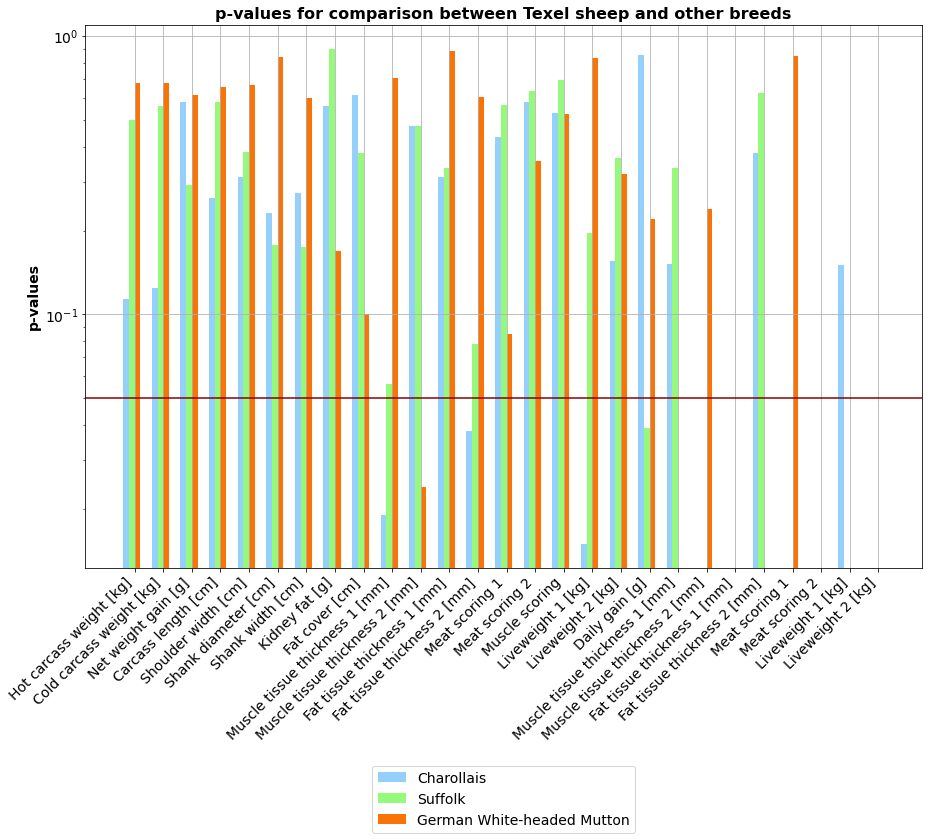

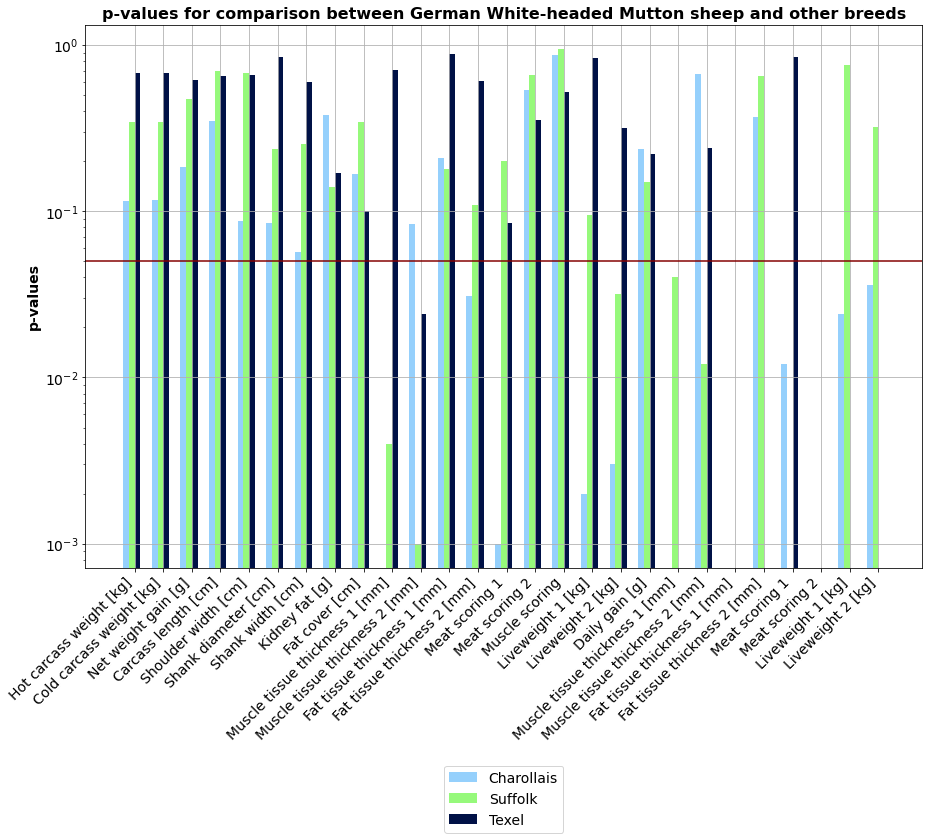

In [9]:
def plot_significancy():
    d = SheepDataEvaluation().significancy()
    #d.rename(cols, axis=1, inplace=True)
    breeds = {1:"Charollais", 2:"Suffolk", 3:"Texel", 4:"German White-headed Mutton"}
    breed_colors = {"Charollais":"xkcd:light blue", "Suffolk":"xkcd:light green", "Texel":"xkcd:navy blue", "German White-headed Mutton":"xkcd:orange"}
    for breed in np.unique(d.index.get_level_values(0)):
        _d = d.loc[pd.IndexSlice[breed,:],:]
        _d.index = _d.index.droplevel(0)
        if breed == "Charollais":
            bdf1 = pd.DataFrame(columns=d.columns, index=_d.index)
        if breed == "Suffolk":
            bdf2 = pd.DataFrame(columns=d.columns, index=_d.index)
        if breed == "Texel":
            bdf3 = pd.DataFrame(columns=d.columns, index=_d.index)
        if breed == "German White-headed Mutton":
            bdf4 = pd.DataFrame(columns=d.columns, index=_d.index)
        for trait in d.columns:
            if breed == "Charollais":
                bdf1.loc[:,trait] = _d.loc[:,trait]
            if breed == "Suffolk":
                bdf2.loc[:,trait] = _d.loc[:,trait]
            if breed == "Texel":
                bdf3.loc[:,trait] = _d.loc[:,trait]
            if breed == "German White-headed Mutton":
                bdf4.loc[:,trait] = _d.loc[:,trait]
    breed1, ax1 = plt.subplots(figsize=(15,10))
    ax1.bar(np.arange(len(bdf1.columns)) - 0.3, bdf1.iloc[0,:], label=bdf1.index[0], color=breed_colors[bdf1.index[0]], width=0.2)
    ax1.bar(np.arange(len(bdf1.columns)) - 0.1, bdf1.iloc[1,:], label=bdf1.index[1], color=breed_colors[bdf1.index[1]], width=0.2)
    ax1.bar(np.arange(len(bdf1.columns)) + 0.1, bdf1.iloc[2,:], label=bdf1.index[2], color=breed_colors[bdf1.index[2]], width=0.2)
    ax1.set_yscale("log")
    ax1.set_xticks(np.arange(len(bdf1.columns)))
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), fontsize=14)
    ax1.set_xticklabels(bdf1.columns, rotation=45, ha="right")
    ax1.tick_params(axis="both", labelsize=14)
    ax1.set_ylabel("p-values", fontsize=14, fontweight="bold")
    ax1.grid()
    ax1.axhline(0.05, 0, 1, color="xkcd:dark red")
    ax1.set_title(f"p-values for comparison between {breeds[1]} sheep and other breeds", fontweight="bold", fontsize=16)
    breed1.savefig(f"../Paper/Inferring of data sets for phenotypic data/Comparison-p-values-{breeds[1]}.png", bbox_inches='tight')
    
    breed2, ax2 = plt.subplots(figsize=(15,10))
    ax2.bar(np.arange(len(bdf2.columns)) - 0.3, bdf2.iloc[0,:], label=bdf2.index[0], color=breed_colors[bdf2.index[0]], width=0.2)
    ax2.bar(np.arange(len(bdf2.columns)) - 0.1, bdf2.iloc[1,:], label=bdf2.index[1], color=breed_colors[bdf2.index[1]], width=0.2)
    ax2.bar(np.arange(len(bdf2.columns)) + 0.1, bdf2.iloc[2,:], label=bdf2.index[2], color=breed_colors[bdf2.index[2]], width=0.2)
    ax2.set_yscale("log")
    ax2.set_xticks(np.arange(len(bdf1.columns)))
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), fontsize=14)
    ax2.set_xticklabels(bdf1.columns, rotation=45, ha="right")
    ax2.tick_params(axis="both", labelsize=14)
    ax2.set_ylabel("p-values", fontsize=14, fontweight="bold")
    ax2.grid()
    ax2.axhline(0.05, 0, 1, color="xkcd:dark red")
    ax2.set_title(f"p-values for comparison between {breeds[2]} sheep and other breeds", fontweight="bold", fontsize=16)
    breed2.savefig(f"../Paper/Inferring of data sets for phenotypic data/Comparison-p-values-{breeds[2]}.png", bbox_inches='tight')
    
    breed3, ax3 = plt.subplots(figsize=(15,10))
    ax3.bar(np.arange(len(bdf3.columns)) - 0.3, bdf3.iloc[0,:], label=bdf3.index[0], color=breed_colors[bdf3.index[0]], width=0.2)
    ax3.bar(np.arange(len(bdf3.columns)) - 0.1, bdf3.iloc[1,:], label=bdf3.index[1], color=breed_colors[bdf3.index[1]], width=0.2)
    ax3.bar(np.arange(len(bdf3.columns)) + 0.1, bdf3.iloc[2,:], label=bdf3.index[2], color=breed_colors[bdf3.index[2]], width=0.2)
    ax3.set_yscale("log")
    ax3.set_xticks(np.arange(len(bdf1.columns)))
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), fontsize=14)
    ax3.set_xticklabels(bdf1.columns, rotation=45, ha="right")
    ax3.tick_params(axis="both", labelsize=14)
    ax3.set_ylabel("p-values", fontsize=14, fontweight="bold")
    ax3.grid()
    ax3.axhline(0.05, 0, 1, color="xkcd:dark red")
    ax3.set_title(f"p-values for comparison between {breeds[3]} sheep and other breeds", fontweight="bold", fontsize=16)
    breed3.savefig(f"../Paper/Inferring of data sets for phenotypic data/Comparison-p-values-{breeds[3]}.png", bbox_inches='tight')
    
    breed4, ax4 = plt.subplots(figsize=(15,10))
    ax4.bar(np.arange(len(bdf4.columns)) - 0.3, bdf4.iloc[0,:], label=bdf4.index[0], color=breed_colors[bdf4.index[0]], width=0.2)
    ax4.bar(np.arange(len(bdf4.columns)) - 0.1, bdf4.iloc[1,:], label=bdf4.index[1], color=breed_colors[bdf4.index[1]], width=0.2)
    ax4.bar(np.arange(len(bdf4.columns)) + 0.1, bdf4.iloc[2,:], label=bdf4.index[2], color=breed_colors[bdf4.index[2]], width=0.2)
    ax4.set_yscale("log")
    ax4.set_xticks(np.arange(len(bdf1.columns)))
    ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), fontsize=14)
    ax4.set_xticklabels(bdf1.columns, rotation=45, ha="right")
    ax4.tick_params(axis="both", labelsize=14)
    ax4.set_ylabel("p-values", fontsize=14, fontweight="bold")
    ax4.grid()
    ax4.axhline(0.05, 0, 1, color="xkcd:dark red")
    ax4.set_title(f"p-values for comparison between {breeds[4]} sheep and other breeds", fontweight="bold", fontsize=16)
    
    breed4.savefig(f"../Paper/Inferring of data sets for phenotypic data/Comparison-p-values-{'-'.join(breeds[4].split())}.png", bbox_inches='tight')
    
plot_significancy()

In [46]:
def randomized(length, percentage):
    res = pd.DataFrame(columns=percentage)
    for x in percentage:
        zeros = np.zeros(length)
        index = np.random.choice(np.arange(length), size=int(length * (x/100)), replace=False)
        zeros[index] = 1
        res.loc[:,x] = zeros
    return res
    
randomized(10000, [2,6,10,15,60,75]).to_csv("/home/thomas/Downloads/10000.csv")

In [23]:
d = SheepDataEvaluation().data()
r = pd.DataFrame()
for models in d:
    res = pd.DataFrame(columns=models.columns, index=np.unique(models.loc[:,"Rasse"]))
    for rasse, values in models.groupby("Rasse"):
        res.loc[rasse, :] = values.mean(axis=0)
    r = pd.concat([r, res], axis=0)
r

Nummer        Vater       Mutter Alter2_Tage Alter3_Tage Gebmonat  \
1  2.76541e+16  3.64469e+16  2.97476e+16      151.92      158.92      1.6   
2  2.76483e+16  3.31555e+16  3.31501e+16       153.2       160.2     1.65   
3  2.76528e+16  3.15863e+16  2.76549e+16     151.286     158.286  1.42857   
4   2.7643e+16  3.49794e+16  3.00357e+16     146.533     153.533  1.57778   
1   2.7601e+14  5.78519e+14  3.84721e+14      170.15      177.15      1.1   
2   2.7601e+14   2.7601e+14   2.7601e+14     162.412     169.412  1.17647   
3   2.7601e+14   2.7601e+14   2.7601e+14         145         152  1.46154   
4   2.7601e+14   2.7601e+14   2.7601e+14     158.077     165.077  1.20513   

    Gebtyp Alter1_Tage Rasse Alter_Mutter_J  ...    TZ2_g Sgwarm_kg Sgkalt_kg  \
1     2.16       95.92     1           1.72  ...  213.703   25.7731   24.5485   
2      1.8        97.2     2           2.05  ...  222.389   25.1221   23.8955   
3  2.07143     95.2857     3        2.28571  ...  222.684   25.2286   24.0005   
4  1.95556     90.5333     4        1.86667  ...  220.271   25.7736   24.5472   
1      2.1      114.15     1            3.1  ...    254.5   30.7273   29.3818   
2        2     106.412     2        4.29412  ...  156.471   24.4857   23.3429   
3  1.92308          89     3        3.23077  ...  243.231    25.875     24.65   
4  1.97436     102.077     4        4.17949  ...  210.436    25.563   24.3704   

  Nettozun Sklaenge_cm Schulterb_cm Keulenu_cm Keulenb_cm Nierenf_g Ofettd_cm  
1  149.432     41.8846      21.2105    70.1872    23.3484   264.196    0.4762  
2  144.679     41.6415       20.918    69.5013    23.0891   260.697  0.474671  
3  145.205     41.6755      20.9536    69.5895    23.1159   264.456  0.479809  
4  149.196     41.8792       21.199    70.1647    23.3336   267.248  0.480878  
1  171.771     43.3636      23.3545    75.5909    25.4636   277.727  0.436364  
2  147.089          43      20.9286    67.3571    22.3571   248.714  0.416667  
3  164.929       41.75      21.8625      71.75         24   246.875     0.425  
4   147.25     41.5926      20.8889    69.8333    23.1444       277  0.525926  

[8 rows x 32 columns]